PyImageJ Tutorial
===

This notebook covers how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including NumPy, SciPy, scikit-image, CellProfiler, OpenCV, ITK and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the other notebooks.

## 1 Starting ImageJ from Python

The [pyimagej](https://pypi.org/project/pyimagej/) module enables access to the entire ImageJ API from Python in a natural way.

Let's initialize an ImageJ gateway including Fiji plugins, at a reproducible version:

In [1]:
import imagej
ij = imagej.init('sc.fiji:fiji')
ij.getVersion()

'2.1.0/1.53c'

### Ways to initialize

| Requirement                                   | Code<sup>1</sup>                                                     | Reproducible?<sup>2</sup> |
|:----------------------------------------------|:---------------------------------------------------------------------|:-------------------------:|
| Newest available version of ImageJ            | `ij = imagej.init()`                                                 | NO                        |
| Specific version of ImageJ                    | `ij = imagej.init('net.imagej:imagej:2.0.0-rc-71')`                  | YES                       |
| With a GUI (newest version)                   | `ij = imagej.init(headless=False)`                                   | NO                        |
| With a GUI (specific version)                 | `ij = imagej.init('net.imagej:imageJ:2.0.0-rc-71', headless=False)`  | YES                       |
| With support for ImageJ 1.x (newest versions) | `ij = imagej.init('net.imagej:imagej+net.imagej:imagej-legacy')`     | NO                        |
| With Fiji plugins (newest version)            | `ij = imagej.init('sc.fiji:fiji')`                                   | NO                        |
| With Fiji plugins (specific version)          | `ij = imagej.init('sc.fiji:fiji:2.0.0-pre-10')`                      | YES                       |
| From a local installation                     | `ij = imagej.init('/Applications/Fiji.app')`                         | DEPENDS                   |

<sup>1</sup> pyimagej uses [`jgo`](https://github.com/scijava/jgo) internally to call up ImageJ, so all of these initializations are tied to the usage of `jgo`. You can read up on the [usage of `jgo`](https://github.com/scijava/jgo#usage) to find out more about this initialization.

<sup>2</sup> ___Reproducible___ means code is stable, executing the same today, tomorrow, and in years to come. While it is convenient and elegant to depend on the newest version of a program, behavior may change when new versions are released—for the better if bugs are fixed; for the worse if bugs are introduced—and people executing your notebook at a later time may encounter broken cells, unexpected results, or other more subtle behavioral differences. You can help avoid this pitfall by pinning to a specific version of the software. The British Ecological Society published [Guide to Better Science: Reproducible Code](https://www.britishecologicalsociety.org/wp-content/uploads/2018/12/BES-Reproducible-Code.pdf) diving into the relevant challenges in more detail, including an [R](https://www.r-project.org/)-centric illustration of best practices. A web search for `reproducible python` also yields several detailed articles.

### 1.2 Increasing the memory available to Java

Java's virtual machine (the JVM) has a "max heap" value limiting how much
memory it can use. You can increase it:

```python
import scyjava_config
scyjava_config.add_options('-Xmx6g')
import imagej
ij = imagej.init()
```

Replace `6g` with the amount of memory Java should have. You can also pass
[other JVM arguments](https://docs.oracle.com/javase/8/docs/technotes/tools/unix/java.html).

Without having specified the max heap value explicitly, here is how much memory this notebook's JVM has available:

In [2]:
ij.getApp().getInfo(True)

'ImageJ 2.1.0/1.53c; Java 1.8.0_252 [amd64]; 34MB of 7045MB'

## 2 A simple example: `ij.py.show()`

ImageJ can display numpy images using `ij.py.show`. Let's demonstrate using `scikit-image` to grab a sample:

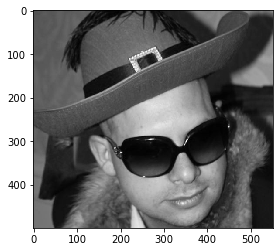

In [3]:
from skimage import io
import numpy as np
img = io.imread('https://samples.fiji.sc/new-lenna.jpg')
img = np.mean(img[500:1000,300:850], axis=2)
ij.py.show(img, cmap = 'gray')

## 3 Converting to Java: `ij.py.to_java`

The function `to_java` is capable of converting common Python and numpy data types into their Java/ImageJ equivalent.  There is one important nuance; converting a numpy array to java creates a java object that points to the numpy array.  This means that **changing the java object also changes the numpy array**.

Let's take a look at lists:

In [4]:
# Lists convert and handle simply
ex_list = [1, 2, 3, 4]
print(type(ex_list))
java_list = ij.py.to_java(ex_list)
print(type(java_list))

<class 'list'>
<java class 'java.util.ArrayList'>


A java list can be accessed the same as a python list. Changing values in the python list does not change values in the java_list

In [5]:
ex_list[0] = 4
java_list[0]

1

By contrast, ops can operate on numpy arrays and change them, though you need to wrap the arrays in `to_java` first.

In [6]:
import numpy as np

arr1 = np.array([[1, 2], [3, 4]])
arr2 = np.array([[5, 6], [7, 8]])
arr_output = ij.py.new_numpy_image(arr1)

ij.op().run('multiply', ij.py.to_java(arr_output), ij.py.to_java(arr1), ij.py.to_java(arr2))
arr_output

array([[ 5, 12],
       [21, 32]])

### 3.1 Technical note for using ops on numpy arrays

Numpy arrays become `RandomAccessibleInterval`s and can substitute for `IterableInterval`s. 

In [7]:
print(type(ij.py.to_java(arr1)))

<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>


If you need to trouble shoot op workings, look for implementations that use only `IterableInterval`s or `RandomAccessibleInterval`s. To find the implementations use the `print(ij.op().help())` function.

For the multiply function the implementation we used is second to last (`net.imagej.ops.math.IIToRAIOutputII$Multiply`)

In [8]:
# print is required to render new lines
print(ij.op().help('multiply'))

Available operations:
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyDouble(
		ArrayImg arg,
		double value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyFloat(
		ArrayImg arg,
		float value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyLong(
		ArrayImg arg,
		long value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyShort(
		ArrayImg arg,
		short value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedLong(
		ArrayImg arg,
		long value)
	(Arr

### 3.2 Process numpy arrays in IJ

`to_java` also works to convert into ImageJ types. Let's grab an image:

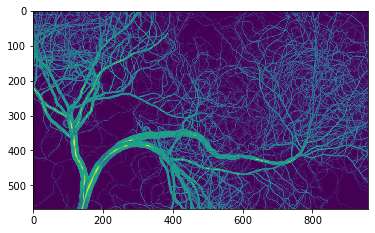

In [9]:
# Import an image with scikit-image.
# NB: Blood vessel image from: https://www.fi.edu/heart/blood-vessels
from skimage import io
url = 'https://www.fi.edu/sites/fi.live.franklinds.webair.com/files/styles/featured_large/public/General_EduRes_Heart_BloodVessels_0.jpg'
img = io.imread(url)
img = np.mean(img, axis=2)
ij.py.show(img)

Any `Op` that requires a `RandomAccessibleInterval` can run on a numpy array that has been passed to `to_java`.  Remember that this method creates a `view`, meaning that the `Op` is **modifying** the underlying Python object:

Let's run a [Difference of Gaussians](https://en.wikipedia.org/wiki/Difference_of_Gaussians) on our numpy image using ImageJ:

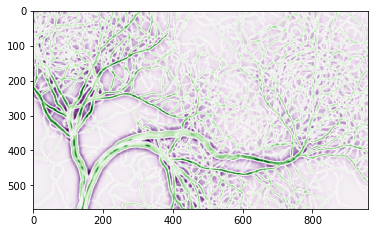

In [10]:
result = np.zeros(img.shape)
# these sigmas will be nice for the larger sections
sigma1 = 8
sigma2 = 2
# note the use of to_java on img and result to turn the numpy images into RAIs
ij.op().filter().dog(ij.py.to_java(result), ij.py.to_java(img), sigma1, sigma2)
# purple highlights the edges of the vessels, green highlights the centers
ij.py.show(result, cmap = 'PRGn')

## 4 Send an ImageJ image into NumPy: `ij.py.from_java`

`from_java` works in reverse of `to_java` and can be used to further process ImageJ data types with numpy, scikit-image, etc. 

Open an image from the url using the IJ scripting interface and then send it to a numpy array.

[java.lang.Enum.toString] 14:26:12.996 [main] DEBUG org.scijava.nativelib.BaseJniExtractor - Not deleting leftover folder /tmp/nativelib-loader_6122312370509698019: is 193996ms old
[java.lang.Enum.toString] 14:26:13.085 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - processor is INTEL_64 os.arch is amd64
[java.lang.Enum.toString] 14:26:13.086 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is LINUX_64 os.name is linux
[java.lang.Enum.toString] 14:26:13.087 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - architecture is LINUX_64 os.name is linux
[java.lang.Enum.toString] 14:26:13.088 [main] DEBUG org.scijava.nativelib.NativeLibraryUtil - platform specific path is natives/linux_64/
[java.lang.Enum.toString] 14:26:13.088 [main] DEBUG org.scijava.nativelib.BaseJniExtractor - mappedLib is libturbojpeg.so
[java.lang.Enum.toString] 14:26:13.090 [main] DEBUG org.scijava.nativelib.BaseJniExtractor - Couldn't find resource natives/linux_64/libturbojpeg.so
[java

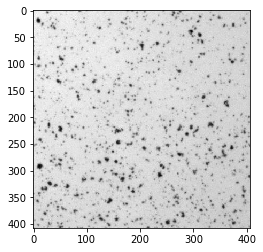

In [11]:
url_colony = 'https://wsr.imagej.net/images/Cell_Colony.jpg'

# Load the image
cell_colony = ij.io().open(url_colony)

# Send it to numpy
numpy_colony = ij.py.from_java(cell_colony)

# Display the image
ij.py.show(numpy_colony, cmap='gray')

### Special Consideration: RGB and other axis conventions

Numpy is reverse indexed from ImageJ, e.g. axis order in numpy is ZYX and in ImageJ is (by default) XYZ.  In addition, numpy and matplotlib have a limited understanding of axis conventions and only natively handle 3-channel RGB images as YXC. To handle this, ImageJ images are converted to rich xarray data, with axes retaining their metadata and properly re-ordered.


In [12]:
# load the image into IJ
ij_img = ij.io().open('https://samples.fiji.sc/new-lenna.jpg')

# Convert the image to a numpy array
img_from_ij = ij.py.from_java(ij_img)

np.shape(img_from_ij)

[java.lang.Enum.toString] [INFO] Populating metadata


(1279, 853, 3)

Note that the channel dimension comes last. The image can be plotted diretly:

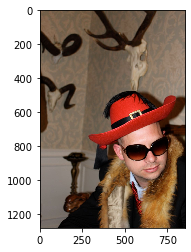

In [13]:
# Hint: There are two barriers to plotting the image: the axis order, and that matplotlib only plot 8-bit RGB images
# convert to 8-bit
img_as_8bit = img_from_ij.astype(int)
# plot the image (xarr)
ij.py.show(img_as_8bit)

## 5 Convenience methods of `ij.py`

These methods can be helpful, especially if you do not know beforehand of which type your image is.

### 5.1 `ij.py.dims`
This can be used to determine the dimensions of a numpy **or** ImageJ image:

In [14]:
# numpy image
img1 = np.zeros([10, 10])
print(ij.py.dims(img1))

# imagej image
img2 = ij.py.to_java(img1)
print(ij.py.dims(img2))

(10, 10)
[10, 10]


### 5.2 `ij.py.new_numpy_image

Takes a single image argument, which can either be a numpy image or an imagej image

In [15]:
# create a new numpy image from a numpy image
img3 = ij.py.new_numpy_image(img1)
print(type(img3))

# create a new numpy image from an imagej image
img4 = ij.py.new_numpy_image(img2)
print(type(img4))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## 6 Running macros, scripts and plugins

### 6.1 Using ImageJ macros: `ij.py.run_macro`

Running an IJ1 style macro is as simple as providing the macro code in a string, and the arguments in a dictionary to run_macro. Modify the following cell to print your name, age, and city.

In [16]:
macro = """
#@ String name
#@ int age
#@ String city
#@output Object greeting
greeting = "Hello " + name + ". You are " + age + " years old, and live in " + city + "."
"""
args = {
    'name': 'Chuckles',
    'age': 13,
    'city': 'Nowhere'
}
result = ij.py.run_macro(macro, args)
print(result.getOutput('greeting'))

Hello Chuckles. You are 13 years old, and live in Nowhere.


[java.lang.Enum.toString] [INFO] script:macro.ijm = [[greeting], [Hello Chuckles. You are 13 years old, and live in Nowhere.]]


Running scripts in other languages is similar, but you also have to specify the file extension for the scripting language it is written in.

In [17]:
language_extension = 'ijm'
result_script = ij.py.run_script(language_extension, macro, args)
print(result_script.getOutput('greeting'))

Hello Chuckles. You are 13 years old, and live in Nowhere.


[java.lang.Enum.toString] [INFO] script:script.ijm = [[greeting], [Hello Chuckles. You are 13 years old, and live in Nowhere.]]


### 6.2 Example: Run a plugin: `ij.py.run_plugin`

Finally, running plugins works in the same manner as macros.  You simply enter the plugin name as a string and the arguments in a dict.  For the few plugins that use IJ2 style macros (i.e., explicit booleans in the recorder), set the optional variable `ij1_style=False`

This example works with IJ1 windows, opening images entirely within IJ and then getting the results.  Working with IJ1 windows requires importing another class, which is done using the jnius framework.  The jnius.autoclass function can import other java classes for similar purposes.

In [18]:
from jpype import JClass
WindowManager = JClass('ij.WindowManager')
ij.py.run_macro("""run("Blobs (25K)");""")
blobs = WindowManager.getCurrentImage()
print(blobs)

img["blobs.gif" (-3), 8-bit, 256x254x1x1x1]


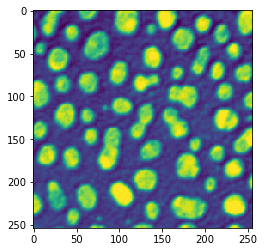

In [19]:
ij.py.show(blobs)

We can now run plugins that require open IJ1 windows on blobs

In [20]:
plugin = 'Mean'
args = { 
    'block_radius_x': 10,
    'block_radius_y': 10
}
ij.py.run_plugin(plugin, args)

<java object 'org.scijava.script.ScriptModule'>

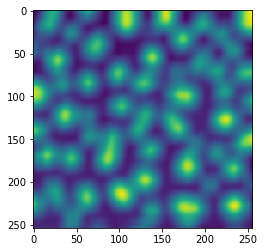

In [21]:
result = WindowManager.getCurrentImage()
result = ij.py.show(result)

You can list any active IJ1 windows with the following command.

In [22]:
print(ij.py.from_java(ij.window().getOpenWindows()))

['blobs.gif']


You can close any IJ1 windows through the following command.

In [23]:
ij.window().clear()
print(ij.py.from_java(ij.window().getOpenWindows()))

[]


## 7 Visualizing large images

Before we begin: how much memory is Java using right now?

In [24]:
from jpype import JClass
Runtime = JClass('java.lang.Runtime')
def java_mem():
    rt = Runtime.getRuntime()
    mem_max = rt.maxMemory()
    mem_used = rt.totalMemory() - rt.freeMemory()
    return '{} of {} MB ({}%)'.format(int(mem_used)/2**20, int(mem_max/2**20), int(100*mem_used/mem_max))

java_mem()

'222.96892547607422 of 7045 MB (3%)'

Now let's open an obnoxiously huge synthetic dataset:

In [25]:
big_data = ij.scifio().datasetIO().open('lotsofplanes&lengths=512,512,16,1000,10000&axes=X,Y,Channel,Z,Time.fake')

How many total samples does this image have?

In [26]:
import numpy as np

dims = [big_data.dimension(d) for d in range(big_data.numDimensions())]
pix = np.prod(dims)
str(pix/2**40) + " terapixels"

'38.14697265625 terapixels'

And how much did memory usage in Java increase?

In [27]:
java_mem()

'995.2045211791992 of 7045 MB (14%)'

Let's visualize this beast. First, we define a function for slicing out a single plane:

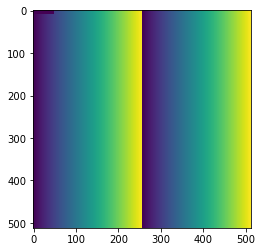

In [28]:
def plane(image, pos):
    while image.numDimensions() > 2:
        image = ij.op().transform().hyperSliceView(image, image.numDimensions() - 1, pos[-1])
        pos.pop()
    return ij.py.from_java(image)

ij.py.show(plane(big_data, [0, 0, 0]))

But we can do better. Let's provide some interaction. First, a function to extract the _non-planar_ axes as a dict:

In [29]:
from jpype import JClass, JObject

CalibratedAxis = JClass('net.imagej.axis.CalibratedAxis')

def axes(dataset):
    axes = {}
    for d in range(2, dataset.numDimensions()):
        axis = JObject(dataset.axis(d), CalibratedAxis)
        label = axis.type().getLabel()
        length = dataset.dimension(d)
        axes[label] = length
    return axes

axes(big_data)

{'Channel': 16, 'Z': 1000, 'Time': 10000}

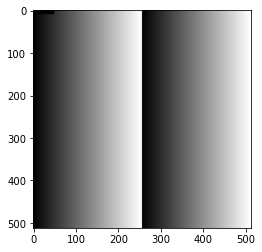

In [30]:
import ipywidgets, matplotlib

widgets = {}
for label, length in axes(big_data).items():
    label = str(label) # HINT: JPype outputs a `java.lang.String` object. Convert to a python string to use with ipywdigets
    widgets[label] = ipywidgets.IntSlider(description=label, max=length-1)

def f(**kwargs):
    matplotlib.pyplot.imshow(plane(big_data, list(kwargs.values())), cmap='gray')
ipywidgets.interact(f, **widgets);

## 8 Troubleshooting

### 8.1 I can't pass my numpy image to an `Op`

`ij.py` is really good at converting numpy images into `RandomAccessibleInterval`s. However many `Op`s, like `addPoissonNoise`, take other forms of ImageJ images, like `IterableInterval`.

In [31]:
print(ij.op().help('filter.addPoissonNoise'))

Available operations:
	(RealType out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseRealType(
		RealType out,
		RealType in,
		long seed?)
	(IterableInterval out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseMap(
		IterableInterval out,
		IterableInterval in)


We can't call this `Op` on a numpy array since it is a specialized type of `RandomAccessibleInterval`, which does not extend `IterableInterval`.

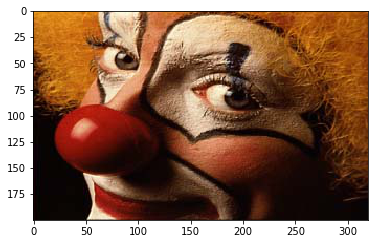

<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>


In [32]:
# Create a numpy image using scikit
img = io.imread('https://imagej.net/images/clown.jpg')

ij.py.show(img)
print(type(ij.py.to_java(img)))

We can fix this by using `transform.flatIterableView` on both the input and output, which will convert the `ReferenceGuardedRandomAccessibleInterval`s into `IterableInterval`s, allowing us to pass our numpy image into `addPoissonNoise`:

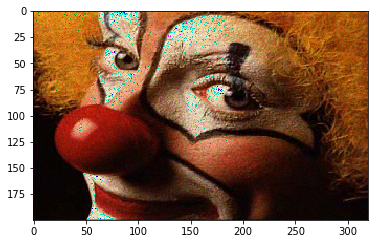

In [33]:
result = ij.py.new_numpy_image(img)

imgIterable = ij.op().transform().flatIterableView(ij.py.to_java(img))
resIterable = ij.op().transform().flatIterableView(ij.py.to_java(result))

ij.op().filter().addPoissonNoise(resIterable, imgIterable)

ij.py.show(result)

Uh oh.

### 8.2 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats of [0..255] for integers

This message is given either because (as described in the warning)

* The data consists of floats that are outside the range of [0..1]. This is pretty common and definitely is the case as to why the above data looks so bad.
* The data consists of ints that are outside the range [0..255].

Let's find out which is the culprit by checking some values of `result`:

In [34]:
# grab the RGB values in a line from [0][5] to [0][10] in our image
print(result[0][5:10])

[[227 180  48]
 [231 164  48]
 [245 160  61]
 [242 177  48]
 [235 164  38]]


Thus we not only have floats outside of [0..1] but also values outside of [0..255]; we are faulty of both points in the warning. We can fix this by first [clipping](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html) the entire array within the integer range, then cast to `uint8` so that the float range no longer applies:

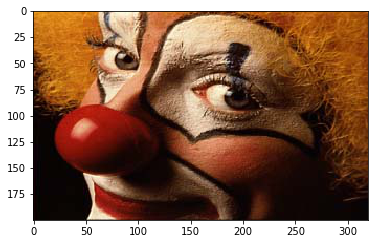

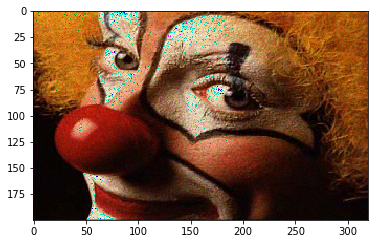

In [35]:
ij.py.show(img.astype(int))
       
result = np.clip(result, 0, 255)
ij.py.show(result.astype(np.uint8))

Now our noisy image displays nicely alongside the original. Note that depending on your data this might not be the right path for you, but using `clip` and `astype` are great tools for rearranging your data within these bounds.